# Green loss calculation
This material is originally developed for ACE 592 Big Data - Empirical Economics written on 8/03/2016 by Akito Kamei, Johnathan Rush, and Peter Christensen. The initial material is modifed for CyberGIS workshop.

### Objective:
* Read world map (shapefile)
* Read green loss satellite file (tiff file)
* Plot data

### Successful outcome:
* Calculate green loss by year

#### Information
Jupyter Notebooks autosave; check the text next to the file name at the top of the screen to see if it has saved before you close the browser tab. You can also go to the File menu and choose Save and Checkpoint, which gives you a place to revert back to if you need it.

If you are done running the notebook, go to File, then Close and Halt to free up system resources for other users. This will clear out all the variables and memory, but any output from the cells you have run will still be displayed. You can run your cells again from the beginning to re-populate variables.

## Step 1: Install packages 

In [1]:
ipak <- function(pkg){
new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
if (length(new.pkg)) 
    install.packages(new.pkg, dependencies = TRUE)
sapply(pkg, require, character.only = TRUE)
}

# usage
packages <- c("rgdal", "sp", "raster",  "gdalUtils", "foreach", "doSNOW")
ipak(packages)

Loading required package: rgdal
Loading required package: sp
rgdal: version: 1.1-10, (SVN revision 622)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 1.11.3, released 2015/09/16
 Path to GDAL shared files: /usr/share/gdal/1.11
 Loaded PROJ.4 runtime: Rel. 4.9.2, 08 September 2015, [PJ_VERSION: 492]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.2-3 
Loading required package: raster
Loading required package: gdalUtils
Loading required package: foreach
Loading required package: doSNOW
Loading required package: iterators
Loading required package: snow


rgdal        sp    raster gdalUtils   foreach    doSNOW 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE

## Step 2: Set the working directory to your user_work folder

In [25]:
#Change to your username
username <- "zhang303"

In [26]:
mydir <- paste("/mnt/jhub/users/", username, sep ="")

In [27]:
mydir

[1] "/mnt/jhub/users/zhang303"

In [5]:
setwd(mydir)

ERROR: Error in setwd(mydir): cannot change working directory


In [6]:
# Confirm the working directory is set to what you wanted:
getwd()

[1] "/mnt/jhub/users/zhang303/r-training-notebooks"

## Step 3: Load the world map polygon data

In [7]:
#Read world map (shapefile)
#Set up a shape folder
setwd("/mnt/jhub/")
# "../../map" is a relative path from your working directory - it means up two directories, then inside the map directory
world=readOGR("shape",layer="ne_110m_admin_0_countries")

OGR data source with driver: ESRI Shapefile 
Source: "shape", layer: "ne_110m_admin_0_countries"
with 177 features
It has 63 fields


### What does the readOGR function do?

In [10]:
#Include a question mark and then a function name to pop up a help window
?readOGR

In [11]:
#You can print an object, or just enter its name to get some information about it.
print(world)

class       : SpatialPolygonsDataFrame 
features    : 177 
extent      : -180, 180, -90, 83.64513  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
variables   : 63
names       : scalerank,      featurecla, labelrank,  sovereignt, sov_a3, adm0_dif, level,              type,       admin, adm0_a3, geou_dif,     geounit, gu_a3, su_dif,     subunit, ... 
min values  :         1, Admin-0 country,         2, Afghanistan,    AFG,        0,     2,           Country, Afghanistan,     AFG,        0, Afghanistan,   AFG,      0, Afghanistan, ... 
max values  :         3, Admin-0 country,         7,    Zimbabwe,    ZWE,        1,     2, Sovereign country,    Zimbabwe,     ZWE,        0,    Zimbabwe,   ZWE,      1,    Zimbabwe, ... 


In [9]:
nrow(world)

[1] 177

In [ ]:
# You can also get information on a class of objects:
?SpatialPolygonsDataFrame

## Step 4: Green loss calculation
We want to find out how much green loss there has been by country, by year. It's good to develop your approach with a small data set to start with so you can rapidly test it.
We will use the east African country of Guinea Bissau.

In [12]:
world_Guinea_Bissau <- subset(world, sovereignt=="Guinea Bissau")

In [13]:
world_Guinea_Bissau@data[,"sovereignt"]

[1] Guinea Bissau
171 Levels: Afghanistan Albania Algeria Angola Antarctica Argentina ... Zimbabwe

In [14]:
# Change the working directory to the directory containing the loss year rasters
setwd("/mnt/jhub/lossyear")

In [15]:
#### Find the raster that overlays Guinea-Bissau
# Read year of green loss satellite file (tiff file)
lossyear_gb <- raster("Hansen_GFC2015_lossyear_20N_020W.tif")

#### Display the metadata for the raster file we just loaded
If you look at a map of Guinea Bissau, you'll see that the country fits entirely within the boundaries expressed by the Corner Coordinates of the raster below.

`gdalinfo` needs a filename to operate on, so we are getting the `name` slot of the `file` slot of the RasterLayer object we just made. Of course, we could have given it `"Hansen_GFC2015_lossyear_20N_020W.tif"`, too.

In [16]:
print(gdalinfo(lossyear_gb@file@name))

 [1] "Driver: GTiff/GeoTIFF"                                                    
 [2] "Files: /mnt/jhub/lossyear/Hansen_GFC2015_lossyear_20N_020W.tif"           
 [3] "Size is 40000, 40000"                                                     
 [4] "Coordinate System is:"                                                    
 [5] "GEOGCS[\"WGS 84\","                                                       
 [6] "    DATUM[\"WGS_1984\","                                                  
 [7] "        SPHEROID[\"WGS 84\",6378137,298.257223563,"                       
 [8] "            AUTHORITY[\"EPSG\",\"7030\"]],"                               
 [9] "        AUTHORITY[\"EPSG\",\"6326\"]],"                                   
[10] "    PRIMEM[\"Greenwich\",0],"                                             
[11] "    UNIT[\"degree\",0.0174532925199433],"                                 
[12] "    AUTHORITY[\"EPSG\",\"4326\"]]"                                        
[13] "Origin = (-20.00000000

#### Make map of Guinea-Bissau region

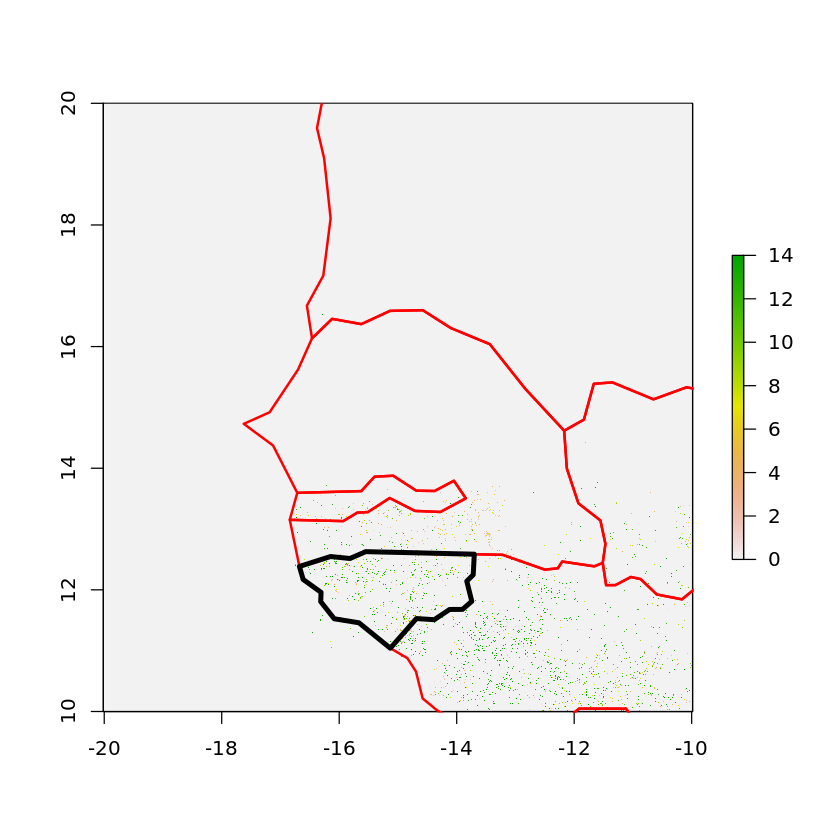

In [17]:
# We start with the raster file, which will set the extent of the map
plot(lossyear_gb, add=FALSE)
plot(world, border="red", lwd = 2, add=TRUE)
plot(world_Guinea_Bissau, border="black", lwd = 4, add=TRUE)

In [18]:
#### Change back to your user directory to work in
setwd(mydir)

ERROR: Error in setwd(mydir): cannot change working directory


## Summarize the green cover loss year in Guinea Bissau
Often, the approach used for this is the `extract` command in the Raster package. However, the performance of `extract` is poor, and uses an enormous amount of memory to allocate the extracted values.

The method below saves computation time by first cropping the raster to the bounding box of the Guinea Bissau polygon, then to the boundaries of the actual polygon, before extracting values. Often, sending smaller input files to a function will speed up the operation, even if many of the values in a large file _should_ be ignored.

The ```ext_gb``` object is a vector of every value extracted from the raster. These are then tabulated so that there is a count of every unique value. Finally, the tabulated summary is transformed into a data frame object.

In [19]:
time1 <- proc.time() #start timer
startTimeGB <- time1
clip1_gb <- crop(lossyear_gb, extent(world_Guinea_Bissau)) #crop to extent of polygon
cat("crop 1:","\n"); proc.time() - time1

time1 <- proc.time() #start timer
clip2_gb <- rasterize(world_Guinea_Bissau, clip1_gb, mask=TRUE) #crops to polygon edge & converts to raster
cat("crop 2:","\n"); proc.time() - time1

time1 <- proc.time() #start timer
ext_gb <- getValues(clip2_gb) #much faster than extract
cat("getValues:","\n"); proc.time() - time1

time1 <- proc.time() #start timer
tab_gb <-table(ext_gb) #tabulates the values of the raster in the polygon
cat("tabulate:","\n"); proc.time() - time1

time1 <- proc.time() #start timer
mat_gb <- as.data.frame(tab_gb)
cat("as.data.frame(tab):","\n"); proc.time() - time1

timeGB <- proc.time() - startTimeGB
cat("Total time to extract raster cell values in Guinea Bissau:\n")
print(summary(timeGB))

crop 1: 


   user  system elapsed 
 26.460   3.340  29.831 

crop 2: 


   user  system elapsed 
 56.364   1.260  60.111 

getValues: 


   user  system elapsed 
  3.524   1.120   4.647 

tabulate: 


   user  system elapsed 
 70.516   1.724  72.315 

as.data.frame(tab): 


   user  system elapsed 
  0.012   0.000   0.010 

Total time to extract raster cell values in Guinea Bissau:
   user  system elapsed 
156.916   7.444 166.959 


#### Take a look at the summarized results data frame


In [20]:
mat_gb

,ext_gb,Freq
1,0,46449432
2,1,41504
3,2,87364
4,3,15212
5,4,72420
6,5,78489
7,6,42564
8,7,119242
9,8,51397
10,9,149150


### Plot the summarized data frame as a bar chart

##### How to make a bar plot?
We'll check the help in the cell below. There, we've used the :: symbol to indicate which specific library's barplot function we want to use.

The `raster` library overrides and extends the built-in `barplot` function from the `graphics` library. So if we just ran `?barplot`, we'd get information on using `raster`'s version. However, there is better information on the basic capabilities of the barplot function in the `graphics` library's help.

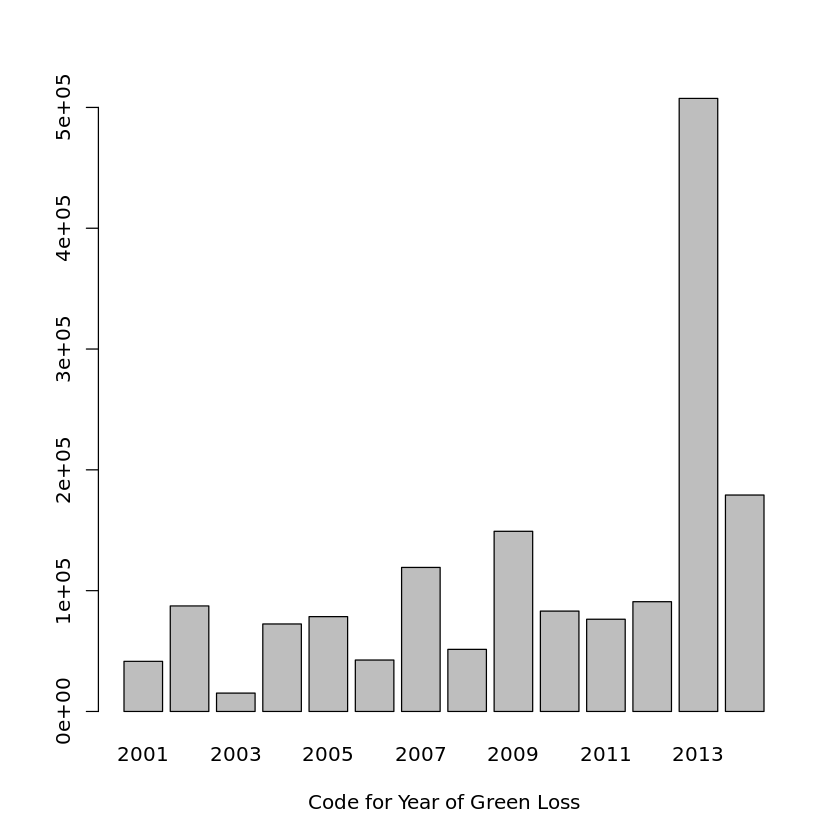

In [21]:
#Using values from position 2 on will exclude the first row - the 0 code for no loss.
# The 0 code is much more common than any other, and would make the plot hard to read.
GBlossyears <- mat_gb$Freq[2:length(mat_gb$Freq)]
GBlosscodes <- mat_gb$ext_gb[2:length(mat_gb$ext_gb)]
#Label setting
GBlosscodes <- factor(GBlosscodes,
levels = c("1","2","3","4","5","6","7","8","9","10","11","12","13","14"),
labels = c("2001","2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014"))

barplot(height = GBlossyears, names.arg = GBlosscodes, xlab = "Code for Year of Green Loss", beside=TRUE)

# Indonesia

### Get a copy of Indonesia's boundaries

In [22]:
world_Indonesia <- subset(world, sovereignt=="Indonesia")

### Build a *virtual raster* for ```lossyear``` files in for the Indonesia region
One raster file covered the entire region of Guinea Bissau, but we will need to use several adjacent rasters to cover Indonesia.

With a virtual raster file, we can reference many files as a single object. Virtual rasters have the file extension ```.vrt```

In [28]:
setwd("/mnt/jhub/lossyear")
#Create a vector of file names for the Indonesia area raster files
ind_lossyear <- c("/mnt/jhub/lossyear/Hansen_GFC2015_lossyear_00N_090E.tif", 
                 "/mnt/jhub/lossyear/Hansen_GFC2015_lossyear_00N_100E.tif", 
                 "/mnt/jhub/lossyear/Hansen_GFC2015_lossyear_00N_110E.tif", 
                 "/mnt/jhub/lossyear/Hansen_GFC2015_lossyear_00N_120E.tif", 
                 "/mnt/jhub/lossyear/Hansen_GFC2015_lossyear_10N_090E.tif", 
                 "/mnt/jhub/lossyear/Hansen_GFC2015_lossyear_10N_100E.tif", 
                 "/mnt/jhub/lossyear/Hansen_GFC2015_lossyear_10N_110E.tif", 
                 "/mnt/jhub/lossyear/Hansen_GFC2015_lossyear_10N_120E.tif", 
                 "/mnt/jhub/lossyear/Hansen_GFC2015_lossyear_10S_120E.tif")

# create a VRT out of the input files, store in your directory
vrtpath <- paste(mydir, "/indonesia.vrt", sep="")
gdalbuildvrt(ind_lossyear, vrtpath)

NULL

### Read in a virtual raster that refers to the TIFF files covering Indonesia

In [29]:
IndRasters <- raster(vrtpath)

In [30]:
# Two ways of getting information on the rasters we've loaded:
print(IndRasters) #print the default information for the raster object
print(gdalinfo(IndRasters@file@name)) #print the results of gdalinfo on the filename

class       : RasterLayer 
dimensions  : 120000, 160000, 1.92e+10  (nrow, ncol, ncell)
resolution  : 0.00025, 0.00025  (x, y)
extent      : 90, 130, -20, 10  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
data source : /mnt/jhub/users/zhang303/indonesia.vrt 
names       : indonesia 
values      : 0, 255  (min, max)

 [1] "Driver: VRT/Virtual Raster"                                               
 [2] "Files: /mnt/jhub/users/zhang303/indonesia.vrt"                            
 [3] "       /mnt/jhub/lossyear/Hansen_GFC2015_lossyear_00N_090E.tif"           
 [4] "       /mnt/jhub/lossyear/Hansen_GFC2015_lossyear_00N_100E.tif"           
 [5] "       /mnt/jhub/lossyear/Hansen_GFC2015_lossyear_00N_110E.tif"           
 [6] "       /mnt/jhub/lossyear/Hansen_GFC2015_lossyear_00N_120E.tif"           
 [7] "       /mnt/jhub/lossyear/Hansen_GFC2015_lossyear_10N_090E.tif"           
 [8] "       /mnt/jhub/lossyear/Hansen_GFC2015_lossyear_10

### Plot the loss rasters with the national boundaries on top

Plotting time for Indonesia: 


user  system elapsed 
 35.628   1.372  37.101

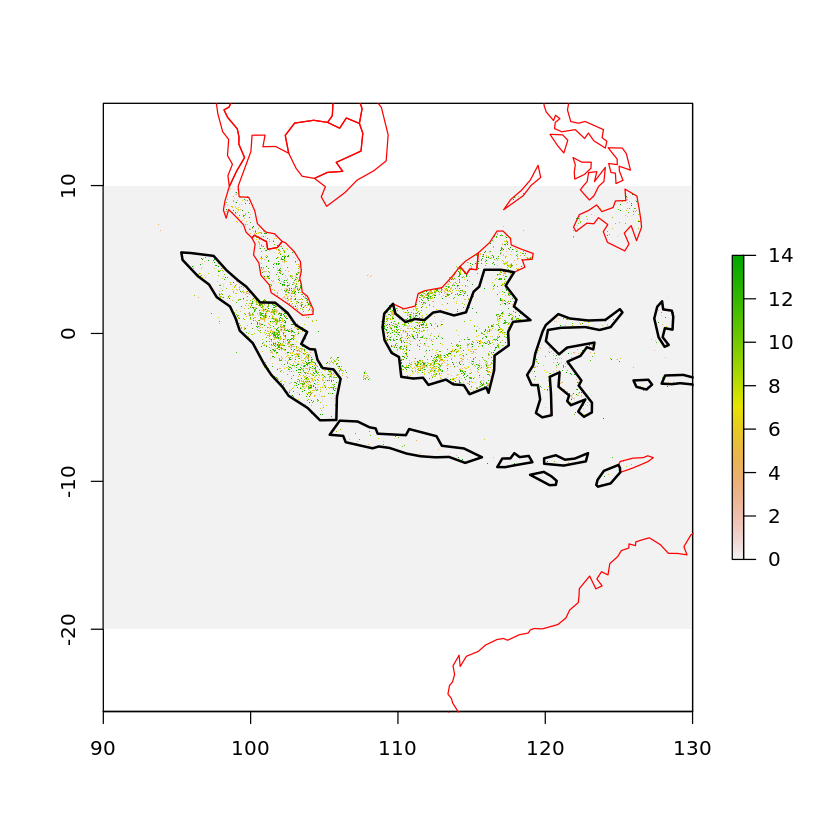

In [31]:
time1 <- proc.time() #start timer

plot(IndRasters, add=FALSE)
plot(world, border="red", lwd = 1, add=TRUE)
plot(world_Indonesia, border="black", lwd = 2, add=TRUE)

time2 <- proc.time() #end timer
cat("Plotting time for Indonesia:","\n")
summary(time2 - time1)

## Extracting raster values from Indonesia
We established earlier that extracting values from Indonesia the usual way would either take too long, or use too much memory.

One data parallelism strategy is called "chunking." Breaking the operations into smaller chunks can let you use more processors at once, as well as better manage how much memory you use.

Below, we will divide Indonesia into smaller pieces and summarize the extracted values from each one. By keeping only what we really want for each chunk - the summary of unique values - we can discard the array of every pixel value from each chunk as soon as we're done summarizing it. This will reduce the amount of memory we need to use at any one time.

After chunking, we will learn how to process many of the chunks at once to speed up computation.

#### How many chunks?
There is a little overhead in terms of storage and communication for every chunk you make, so you don't want to split up the source data _too_ much. One way to estimate if we are hitting the right balance is to take a look at the plotted map after we have the chunks. Better methods include checking the number of pixels in a chunk, the memory used by the values extracted for a chunk, or the ratio of a chunk's area to the area of a region we have already calculated (like Guinea Bissau).

In [32]:
time1 <- proc.time() #start timer

# Get extent for country
ind_yext <- world_Indonesia@bbox["y","max"] - world_Indonesia@bbox["y","min"]
ind_xext <- world_Indonesia@bbox["x","max"] - world_Indonesia@bbox["x","min"]
cat("Indonesia longitude extent: ", ind_xext, "; latitude extent: ", ind_yext)

# Divide lat/long extents by U/V increments to create new polygons
# Here, we've manually chosen divisions, but you can imagine setting a maximum width for these
udiv = 45; vdiv = 15;

# Extent in map units for each rectangle
ind_yint <- ind_yext / vdiv
ind_xint <- ind_xext / udiv

# What is the size of each rectangle?
cat("\nSubdivision rectangle width:  ", ind_xint)
cat("\nSubdivision rectangle height: ", ind_yint)

#initialize an empty list with the length to hold all the grid cells we will create
polys <- vector("list", udiv*vdiv) #make a vector of type list, with a length of udiv * vdiv

#loop
for (u in 1:udiv){
    for (v in 1:vdiv){     
        #store the calculated extents as polygons in an indexed array
        polys[[(u-1)*vdiv+v]] <- as(extent(world_Indonesia@bbox["x","min"] + ind_xint * (u-1),
                                           world_Indonesia@bbox["x","min"] + ind_xint * u, 
                                           world_Indonesia@bbox["y","min"] + ind_yint * (v-1),
                                           world_Indonesia@bbox["y","min"] + ind_yint * v),
                                     'SpatialPolygons')
    }
}

#merge polygons - this calls the bind function on each polygon to make them a single object
merged_polys <- do.call(bind, polys) 

#set the projection of these new shapes to the same as is used for our Indonesia shape
projection(merged_polys) <- projection(world_Indonesia)

cat("\nSubdivision rectangle creation time","\n"); proc.time() - time1

Indonesia longitude extent:  45.74083 ; latitude extent:  15.83981
Subdivision rectangle width:   1.016463
Subdivision rectangle height:  1.055987
Subdivision rectangle creation time 


   user  system elapsed 
  2.084   0.032   2.118 

#### Plot the newly created cells to check that they look correct

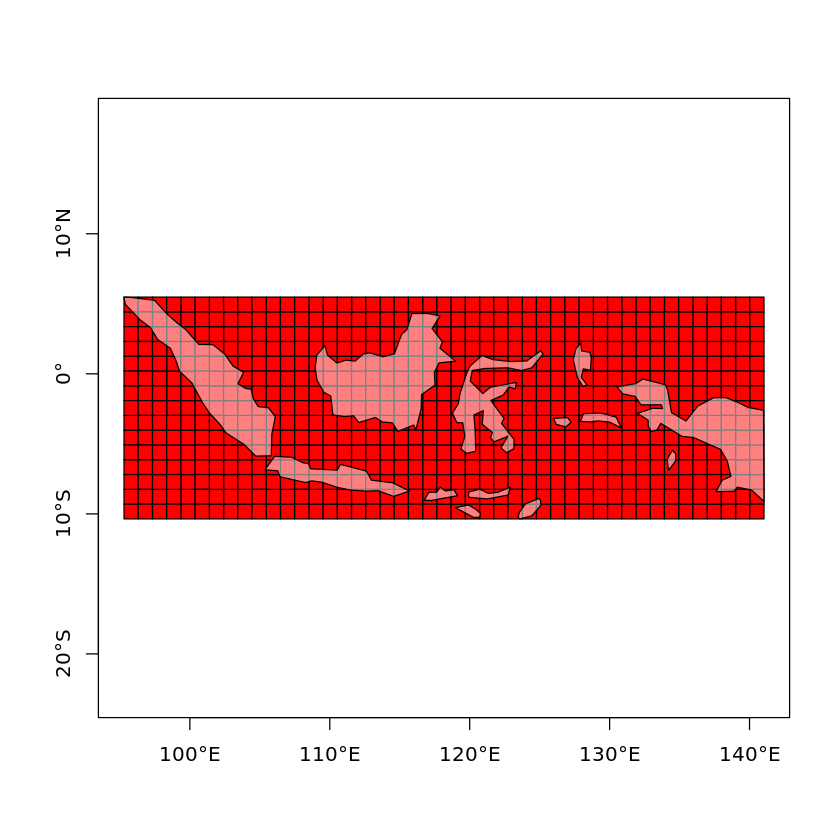

In [33]:
plot(merged_polys, col='red', axes=TRUE)
plot(world_Indonesia, col=rgb(1,1,1,0.5), add=TRUE)

## Intersected result

Loading required namespace: rgeos


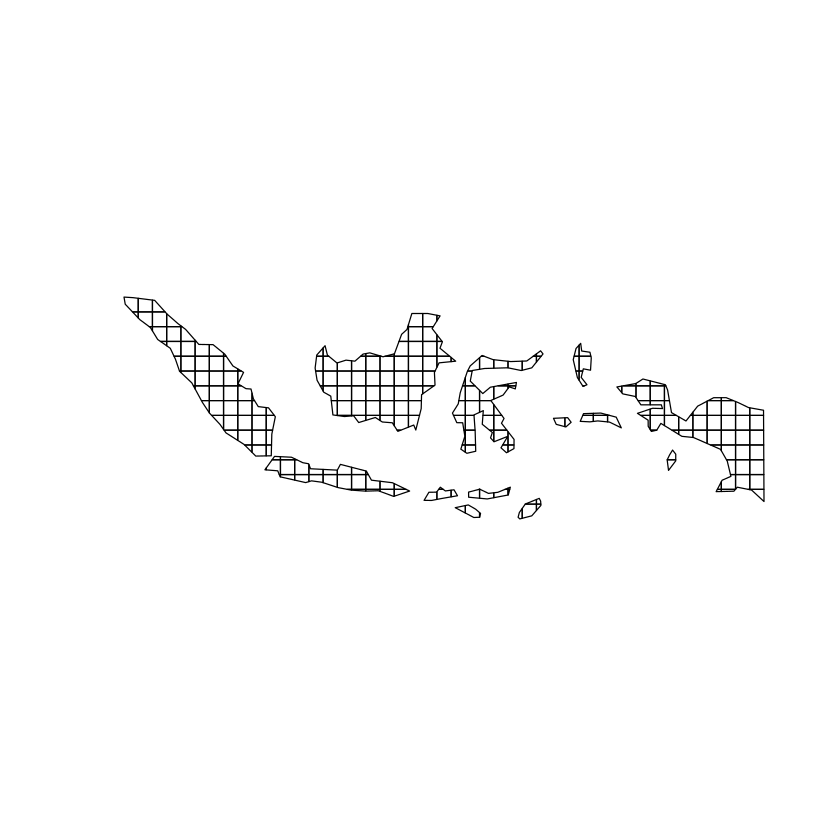

In [34]:
#Intersected chunks with country shape
chunks_Ind <- intersect(world_Indonesia, merged_polys)
plot(chunks_Ind)

#### How many cells overlapped with Indonesia?

In [35]:
length(chunks_Ind)

[1] 267

### Extract values from Indonesia chunks - Serial version

In [38]:
shapecount <- length(chunks_Ind) # total number of chunks

endcount <- 10 # choose a number less than shapecount for testing
mat <- vector("list", endcount)

extractor <- function(p){
    clip1_Ind <- crop(IndRasters, extent(chunks_Ind[p,])) #crop to extent of polygon
    clip2_Ind <- rasterize(chunks_Ind[p,], clip1_Ind, mask=TRUE)
    ext <- getValues(clip2_Ind) #much faster than raster::extract
    #print(ext)
    tab<-table(ext) #tabulates the values of the raster in the polygon
    #print(tab)
}

starttimeInd <- proc.time() #begin time

#apply (run) the extractor function for each chunk of Indonesia, up to the endcount limit
tablesInd <- lapply(1:endcount, function(p) extractor(p)) 
    
dfInd <- do.call(cbind, tablesInd) #call the cbind (combine by columns) function on each table in the `tablesInd` list
endtimeInd <- proc.time() #end time

cat("Time to extract values from ", endcount, " polygons:\n")
print(summary(endtimeInd - starttimeInd))

cat("\nEstimated total time for serial extraction of all Indonesia values:\n")
cat((endtimeInd - starttimeInd)[[3]] * length(chunks_Ind) / endcount / 60, " minutes")

#dfInd is a data frame with a column for every table from the tablesInd list.
# Sum across each row to get the frequency of each raster value
sumInd <- as.data.frame(rowSums(dfInd)) 
colnames(sumInd) <- "Freq" #assign the name Freq to the column in the data frame to be consistent with Guinea Bissau method
sumInd

Warning message:
In (function (..., deparse.level = 1) : number of rows of result is not a multiple of vector length (arg 10)

Time to extract values from  10  polygons:
   user  system elapsed 
243.124   5.588 249.821 

Estimated total time for serial extraction of all Indonesia values:
111.1703  minutes

,Freq
0,76269295
1,272504
2,159097
3,188537
4,245922
5,228593
6,325977
7,352234
8,507068
9,916839


### Extract values from Indonesia chunks - Parallel version
As above, but using `foreach` instead of `lapply`. 

In [40]:
shapecount <- length(chunks_Ind) # total number of chunks

endcount <- 10 # use the same number as the above serial version to measure speedup
              # SET TO SHAPECOUNT to extract data for all of Indonesia
extractor <- function(p){1
    clip1_Ind <- crop(IndRasters, extent(chunks_Ind[p,])) #crop to extent of polygon
    clip2_Ind <- rasterize(chunks_Ind[p,], clip1_Ind, mask=TRUE)
    ext <- getValues(clip2_Ind) #much faster than raster::extract
    tab<-table(ext) #tabulates the values of the raster in the polygon
}


cluster = makeCluster(10, type = "SOCK")
registerDoSNOW(cluster)
clusterExport(cluster, c("IndRasters","chunks_Ind", "extractor"))
starttimeInd <- proc.time() #begin time   
results = foreach(n = 1:endcount, .combine = cbind) %dopar% {
     library(raster); 
     #Define function
     extractor(n)
}
#results
endtimeInd <- proc.time() #end time
stopCluster(cluster)

cat("Time to extract values from ", endcount, " polygons:\n")
print(summary(endtimeInd - starttimeInd))
 
sumInd <- as.data.frame(rowSums(results))
colnames(sumInd) <- "Freq"
sumInd




Warning message:
In fun(result.1, result.2, result.3, result.4, result.5, result.6, : number of rows of result is not a multiple of vector length (arg 10)

Time to extract values from  10  polygons:
   user  system elapsed 
  0.080   0.000  51.842 


,Freq
0,76269295
1,272504
2,159097
3,188537
4,245922
5,228593
6,325977
7,352234
8,507068
9,916839


## Q1: How much did a parallel code speed up a sequential code?
Sp = Ts / Tp
- p = # of processors
- Ts = execution time of the sequential code
- Tp = execution time of the parallel code with p processors